# Insomnia
Training a model to predict whether I will have insomnia that night.

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import run_yasa
import logging
import mne
import yasa
import os
import argparse
import os

import mne
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
from brainflow.data_filter import DataFilter
log = lambda msg: logging.info(msg)

pd.set_option('display.max_columns', 100)


# Load data

In [2]:
input_dir = "C:\\dev\\play\\brainwave-data"
stats_df = pd.read_csv(input_dir + os.path.sep + "stats.csv")


In [3]:

from sleep_events import connect_to_firebase


# def load_sleep_events(log, start_date, end_date, waking_start_time_tz, waking_end_time_tz):
db = connect_to_firebase()

docs = db.collection('daysExperimental').stream()

# Convert to list of dictionaries
records = [doc.to_dict() for doc in docs]

days = pd.DataFrame(records)
days

,timestampWritten,ml,dayAndNightOf,ui
0,2024-10-11 12:37:47.173000+00:00,"{'drugsAndSupplements:RybelsusQuantity': 0, 'w...",2024-04-21,"{'bedroomEnvironment': None, 'weather': {'prec..."
1,2024-10-11 12:37:48.766000+00:00,{'exercise:fitbit:heartRateZones:OutofRange:ma...,2024-04-22,{'eeg': {'wakeToMidday': {'F8-M1': {'algo1': {...
2,2024-10-11 12:37:50.160000+00:00,{'exercise:fitbit:heartRateZones:OutofRange:mi...,2024-04-23,"{'date': {'month': 4, 'daysSince': 0, 'dayOfWe..."
3,2024-10-11 12:37:51.331000+00:00,{'exercise:fitbit:heartRateZones:FatBurn:calor...,2024-04-24,"{'sunrise': {'sunsetDurationMillis': 2257000, ..."
4,2024-10-11 12:37:52.900000+00:00,{'exercise:fitbit:activityLevels:lightly:dista...,2024-04-25,"{'date': {'daysSince': 0, 'month': 4, 'dayOfWe..."
...,...,...,...,...
192,2024-11-03 08:45:20.976000+00:00,{'night:fitbit:adjusted:betweenReadyToSleepAnd...,2024-10-30,{'hrv': {'GotIntoBedToReadyToSleep': {'median'...
193,2024-11-03 08:45:06.824000+00:00,{'coreBodyTemp:MiddayToReadyToSleep:mean:onDay...,2024-10-31,{'hr': {'MiddayToReadyToSleep': {'percentile90...
194,2024-11-03 08:44:49.359000+00:00,{'night:fitbit:adjusted:betweenReadyToSleepAnd...,2024-11-01,{'hrv': {'GotIntoBedToReadyToSleep': {'percent...
195,2024-11-03 08:44:37.516000+00:00,{'night:yasaExtended:N3:dt_s:percentile10:onDa...,2024-11-02,{'coreBodyTemp': {'MiddayToReadyToSleep': {'pe...


In [4]:
import pandas as pd
from pandas import json_normalize
import json

df = days
# Assuming yasa_df is your DataFrame and 'ML' is the column containing JSON data
json_column = 'ml'

# Explode the JSON column into separate columns
exploded_df = json_normalize(df[json_column])

# Merge the new DataFrame with the 'dayAndNightOf' column
result_df = pd.concat([df['dayAndNightOf'], exploded_df], axis=1)

# Drop all other columns except 'dayAndNightOf' and the new columns from the JSON data
result_df = result_df.loc[:, ~result_df.columns.duplicated()]


In [ ]:
result_df

In [66]:
[col for col in result_df.columns if 'yasa' in col]

['night:yasaExtended:N2:sigmaabs_s:percentile25',
 'night:yasaExtended:N3:ds_s:mean',
 'night:yasaExtended:N2:beta_s:percentile10',
 'night:yasaExtended:N2:abspow_s:percentile10',
 'night:yasaExtended:Sleep:std_s:mean',
 'night:yasaExtended:N2:dt_s:percentile75',
 'night:yasaExtended:N3:ds_s:percentile90',
 'night:yasaExtended:N2:perment_s:percentile90',
 'night:yasaExtended:NREM:hcomp_s:mean',
 'night:yasaExtended:Sleep:abspow_s:percentile75',
 'night:yasaExtended:Sleep:theta_s:percentile10',
 'night:yasaExtended:Stability:O2-M1:N1',
 'night:yasaExtended:NREM:ds_s:percentile25',
 'night:yasaExtended:W:perment_s:percentile90',
 'night:yasa:source:totalSleepTimeSecs',
 'night:yasaExtended:N1:hmob_s:percentile25',
 'night:yasaExtended:N3:skew_s:percentile10',
 'night:yasaExtended:R:auc_s:percentile10',
 'night:yasaExtended:N2:db_s:percentile75',
 'night:yasaExtended:N2:theta_s:percentile75',
 'night:yasaExtended:All:auc_s:percentile10',
 'night:yasaExtended:Sleep:auc_s:mean',
 'night:yas

In [9]:
time_awake_columns = [col for col in result_df.columns if 'timeAwakeAfterSleepSecs' in col]
print(time_awake_columns)

['night:fitbit:source:timeAwakeAfterSleepSecs', 'night:aggregated:timeAwakeAfterSleepSecs', 'night:fitbit:adjusted:timeAwakeAfterSleepSecs', 'night:fitbit:source:timeAwakeAfterSleepSecs:onDayMinus1', 'night:aggregated:timeAwakeAfterSleepSecs:vsDayMinus1', 'night:fitbit:source:timeAwakeAfterSleepSecs:vsDayMinus1', 'night:aggregated:timeAwakeAfterSleepSecs:onDayMinus1', 'night:fitbit:adjusted:timeAwakeAfterSleepSecs:vsDayMinus1', 'night:fitbit:adjusted:timeAwakeAfterSleepSecs:onDayMinus1', 'night:yasa:adjusted:timeAwakeAfterSleepSecs', 'night:yasa:source:timeAwakeAfterSleepSecs', 'night:yasa:adjusted:timeAwakeAfterSleepSecs:onDayMinus1', 'night:yasa:source:timeAwakeAfterSleepSecs:onDayMinus1', 'night:yasa:source:timeAwakeAfterSleepSecs:vsDayMinus1', 'night:yasa:adjusted:timeAwakeAfterSleepSecs:vsDayMinus1']


In [52]:
result_df["timeAwakeAfterSleepMins"] = result_df["night:yasa:adjusted:timeAwakeAfterSleepSecs"] / 60
result_df["hadInsomnia"] = (result_df["timeAwakeAfterSleepMins"] >= 60).astype(int)
result_df["hadInsomnia"].value_counts()

hadInsomnia
0    179
1     18
Name: count, dtype: int64

In [54]:
result_df["timeAwakeAfterSleepMins"].value_counts()

timeAwakeAfterSleepMins
8.300000      1
57.700000     1
31.183333     1
37.766667     1
39.933333     1
79.850000     1
180.950000    1
40.700000     1
36.950000     1
71.316667     1
54.700000     1
36.466667     1
44.733333     1
41.783333     1
39.316667     1
29.383333     1
78.283333     1
221.500000    1
34.750000     1
49.116667     1
39.416667     1
107.733333    1
60.733333     1
26.116667     1
46.033333     1
46.350000     1
56.116667     1
49.533333     1
23.516667     1
67.216667     1
61.350000     1
51.516667     1
420.133333    1
245.366667    1
34.133333     1
22.216667     1
212.833333    1
141.883333    1
104.816667    1
75.450000     1
100.516667    1
352.433333    1
40.050000     1
54.900000     1
282.100000    1
31.750000     1
51.833333     1
37.950000     1
Name: count, dtype: int64

In [56]:
result_df[["hadInsomnia", "timeAwakeAfterSleepMins"]].dropna()

,hadInsomnia,timeAwakeAfterSleepMins
78,0,8.300000
81,0,57.700000
82,0,49.533333
83,0,23.516667
92,1,67.216667
97,1,61.350000
119,0,51.516667
120,1,420.133333
121,1,245.366667
122,0,34.133333


# Prepare data

In [81]:
from dataclasses import dataclass
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
import pandas as pd
import json


import pandas as pd
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline

# Custom Transformer to remove highly correlated percentile columns
class RemoveHighlyCorrelatedColumns(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.97):
        self.threshold = threshold
        self.columns_to_remove_ = []

    def fit(self, X, y=None):
        # Iterate through each column in X
        for col in X.columns:
            # Replace "percentile90" or "percentile10" with "mean"
            new_col = col.replace('percentile90', 'mean').replace('percentile10', 'mean')

            # Check if the new "mean" column exists and it's not the same as the original column
            if new_col in X.columns and col != new_col:
                # Calculate the correlation
                correlation = X[col].corr(X[new_col])

                # If correlation is greater than or equal to the threshold, mark the column for removal
                if correlation >= self.threshold:
                    self.columns_to_remove_.append(col)

        return self

    def transform(self, X, y=None):
        # Drop the columns that are highly correlated with their corresponding mean columns
        return X.drop(columns=self.columns_to_remove_, errors='ignore')


class RowsWithTargetCol(BaseEstimator, TransformerMixin):
    def __init__(self, target_col):
        self.target_col = target_col
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return result_df[~result_df[self.target_col].isna()]

class RowsWithRequirements(BaseEstimator, TransformerMixin):
    def __init__(self, require_eeg: bool):
        self.require_eeg = require_eeg

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.require_eeg:
            # Any YASA/EEG col will do
            return X[~X["night:yasa:adjusted:timeAwakeAfterSleepSecs"].isna()]
        return X


class UsefulFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, target_col, sources: list[str]):
        self.target_col = target_col
        self.sources = sources
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Just not really ready for primetime
        not_ready_for_primetime = ["presence:", "settling:"]
        useless = ["generatedAt"]
        do_not_want_in_model = ["date:"]
        too_close_to_target = ["timeAwake", "wakePct", "efficiencyTotalSleep", "waking", "WASO"]
        # Will want to use adjusted instead
        duplicates = ["night:fitbit:source:", "night:yasa:source:"]
        remove_list = not_ready_for_primetime + useless + do_not_want_in_model + duplicates + too_close_to_target
        
        useful_features = [col for col in X.columns \
                           if (self.target_col in col) \
                            or not any(rem in col for rem in remove_list)
                           ]
        
        return X[useful_features].select_dtypes(include=[np.number])



# Drop columns where we don't have much data
class DropFewValidColumns(BaseEstimator, TransformerMixin):
    def __init__(self, min_valid=5):
        self.min_valid = min_valid  # Minimum valid values required to keep the column
        self.columns_to_keep_ = None  # Will store the columns to keep

    def fit(self, X, y=None):
        # Identify columns where the count of non-NaNs is at least min_valid
        valid_counts = X.notna().sum()
        self.columns_to_keep_ = valid_counts[valid_counts >= self.min_valid].index.tolist()
        return self  # Return self to comply with scikit-learn's fit API

    def transform(self, X, y=None):
        # Keep only the identified columns with at least min_valid non-NaNs
        return X[self.columns_to_keep_]


@dataclass
class ModelAndData:
    name: str
    target_col: str
    is_binary: bool
    sources: list[str]
    prepared_df: pd.DataFrame
    X: pd.DataFrame
    y: pd.Series
    model: object = None
    X_train: pd.DataFrame = None
    y_train: pd.Series = None
    X_val: pd.DataFrame = None
    y_val: pd.Series = None


modelsAndData: list[ModelAndData] = []

def create_and_add(target_col: str, sources: list[str], input, is_binary: bool, require_eeg: bool):
    name = f"target:{target_col} sources:{sources}"

    pipeline = Pipeline([
        ('rows', RowsWithTargetCol(target_col)),
        ('rows_with_reqs', RowsWithRequirements(require_eeg)),
        ('features', UsefulFeatures(target_col, sources)),
        ('drop_few_values', DropFewValidColumns()),
        ('remove_highly_correlated', RemoveHighlyCorrelatedColumns(threshold=0.97)),
    ])

    prepared_df = pipeline.fit_transform(input)

    X = prepared_df.drop(columns=[target_col])
    y = prepared_df[target_col]

    md = ModelAndData(name, target_col, is_binary, sources, prepared_df, X, y)
    modelsAndData.append(md)


create_and_add("timeAwakeAfterSleepMins", ["all"], result_df, False, True)
create_and_add("hadInsomnia", ["all"], result_df, True, True)

C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [82]:
modelsAndData[1].y.value_counts()

hadInsomnia
0    30
1    18
Name: count, dtype: int64

In [83]:
from sklearn.model_selection import train_test_split

def split(modelAndData: ModelAndData):
    X_train_to_sleep, X_val_to_sleep, y_train_to_sleep, y_val_to_sleep = train_test_split(modelAndData.X, modelAndData.y, test_size=0.2, random_state=42)
    modelAndData.X_train = X_train_to_sleep
    modelAndData.y_train = y_train_to_sleep
    modelAndData.X_val = X_val_to_sleep
    modelAndData.y_val = y_val_to_sleep

for md in modelsAndData:
    split(md)
    print(f"Training set size {md.name}: {len(md.X_train)}, validation set size: {len(md.X_val)}")

Training set size target:timeAwakeAfterSleepMins sources:['all']: 38, validation set size: 10
Training set size target:hadInsomnia sources:['all']: 38, validation set size: 10


# Train XGBoost model

In [90]:
from catboost import CatBoostRegressor, CatBoostClassifier

def train(md: ModelAndData):
    if md.is_binary:
        md.model = CatBoostClassifier(
            eval_metric='Logloss',             # Logarithmic loss for classification
            loss_function='Logloss',           # Loss function for classification
            iterations=1000,                    # Number of boosting iterations
            learning_rate=0.03,                # Learning rate
            depth=10,                           # Depth of the tree
            early_stopping_rounds=50           # Early stopping rounds
        )
    else:
        md.model = CatBoostRegressor(
            eval_metric='RMSE',             # Root Mean Squared Error
            loss_function='RMSE',           # Loss function for regression
            iterations=1000,                # Number of boosting iterations
            learning_rate=0.03,             # Learning rate
            depth=6,                        # Depth of the tree
            early_stopping_rounds=50        # Early stopping rounds
        )

    log(f"Training model for {md}")
    md.model.fit(md.X_train, md.y_train, verbose=100)

train(modelsAndData[0])

# for md in modelsAndData:
#     if md.is_binary:
#         train(md)

0:	learn: 86.9942454	total: 35.9ms	remaining: 35.8s
100:	learn: 37.5391378	total: 4.03s	remaining: 35.9s
200:	learn: 15.8672719	total: 7.59s	remaining: 30.2s
300:	learn: 7.1930630	total: 11.4s	remaining: 26.4s
400:	learn: 3.3672233	total: 14.8s	remaining: 22.1s
500:	learn: 1.5911702	total: 18.1s	remaining: 18.1s
600:	learn: 0.7602694	total: 21.5s	remaining: 14.3s
700:	learn: 0.3576375	total: 25.1s	remaining: 10.7s
800:	learn: 0.1686940	total: 28.8s	remaining: 7.17s
900:	learn: 0.0784178	total: 37.6s	remaining: 4.13s
999:	learn: 0.0376284	total: 41.4s	remaining: 0us


# Evaluate the model

Evaluation for model:  target:timeAwakeAfterSleepMins sources:['all']
target:timeAwakeAfterSleepMins sources:['all'] Training Set Evaluation:
target:timeAwakeAfterSleepMins sources:['all'] Mean Absolute Error (MAE): 0.02806278982834754
target:timeAwakeAfterSleepMins sources:['all'] Mean Squared Error (MSE): 0.001415988415541553
target:timeAwakeAfterSleepMins sources:['all'] Root Mean Squared Error (RMSE): 0.03762962151738379
target:timeAwakeAfterSleepMins sources:['all'] Validation Set Evaluation:
target:timeAwakeAfterSleepMins sources:['all'] Mean Absolute Error (MAE): 39.678718597767684
target:timeAwakeAfterSleepMins sources:['all'] Mean Squared Error (MSE): 3761.4749880189133
target:timeAwakeAfterSleepMins sources:['all'] Root Mean Squared Error (RMSE): 61.33086488888701


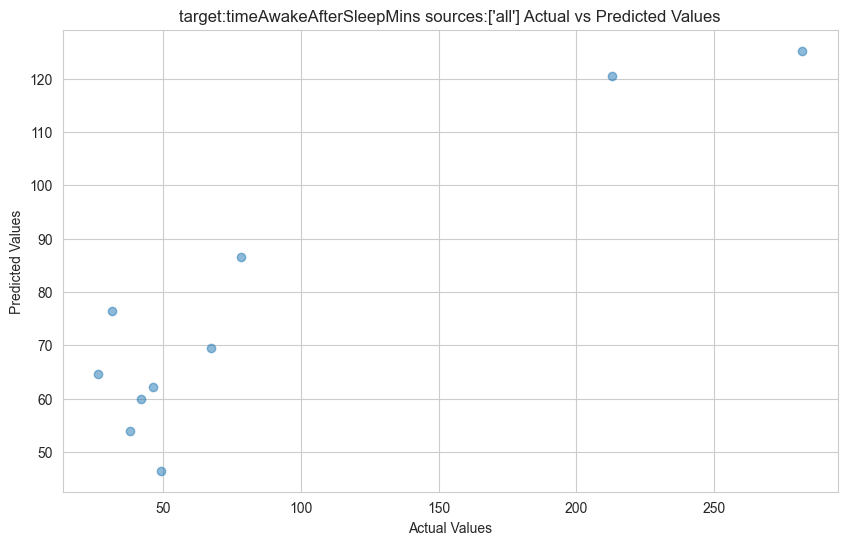

In [91]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(md: ModelAndData, model, X, y):
    # Predict the target values using the trained model
    predictions = model.predict(X)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, predictions)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y, predictions)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    print(f"{md.name} Mean Absolute Error (MAE): {mae}")
    print(f"{md.name} Mean Squared Error (MSE): {mse}")
    print(f"{md.name} Root Mean Squared Error (RMSE): {rmse}")

    return mae, mse, rmse

def eval2(md: ModelAndData, X_train, y_train, X_val, y_val):
    model = md.model
    print("Evaluation for model: ", md.name)
    # Evaluate the model on the training set
    print(f"{md.name} Training Set Evaluation:")
    train_mae, train_mse, train_rmse = evaluate_model(md, model, X_train, y_train)
    
    # Evaluate the model on the validation set
    print(f"{md.name} Validation Set Evaluation:")
    val_mae, val_mse, val_rmse = evaluate_model(md, model, X_val, y_val)
    
    # Predict the target values using the trained model
    val_predictions = model.predict(X_val)
    
    # Create a DataFrame with y_val and the predictions
    results_df = pd.DataFrame({
        'Actual': y_val,
        'Predicted': val_predictions,
        'Original': result_df.loc[y_val.index, 'timeAwakeAfterSleepMins']
    })

    if md.target_col == "hadInsomnia":
        print(results_df)
        cm = confusion_matrix(results_df['Actual'], results_df['Predicted'])
    
        # Plot the confusion matrix
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    else:
        # Plot a scatter plot of y_val vs predictions
        plt.figure(figsize=(10, 6))
        plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'{md.name} Actual vs Predicted Values')
        plt.grid(True)
        plt.show()


md = modelsAndData[0]
eval2(md, md.X_train, md.y_train, md.X_val, md.y_val)

# for md in modelsAndData:
#     eval2(md, md.X_train, md.y_train, md.X_val, md.y_val)

In [80]:
modelsAndData[1].model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,night:yasaExtended:All:std_s:percentile75,9.929689
1,night:yasaExtended:All:betaabs_s:percentile90,5.885892
2,night:yasaExtended:All:iqr_s:percentile75,4.930260
3,night:yasaExtended:Statistics:SE,3.077699
4,night:yasaExtended:R:ds_s:percentile25,2.560732
...,...,...
5076,events:gotOutOfBed:firstSSM,0.000000
5077,drugsAndSupplements:MultivitLastSSM:vsDayMinus1,0.000000
5078,events:gotOutOfBed:lastSSM,0.000000
5079,events:startingPaidWork:firstSSM,0.000000
